In [1]:
from keras.models import Model
import keras.models
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from keras import backend as K

import cnn_builder as cbuild
import config
import csv
import niftiutils.helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import random
%matplotlib inline

from scipy.misc import imsave

Using TensorFlow backend.


In [73]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
C = config.Config()
T = config.Hyperparams()
#T.get_best_hyperparams()

In [ ]:
cbuild.run_fixed_hyperparams([C], hyperparams=T)#C_list)

C_list = [config.Config(), config.Config()]
C_list[0].dims = [36,36,12]
C_list[1].dims = [24,24,12]
C_list[0].artif_dir = "E:\\imgs\\artif_imgs_3612\\"
C_list[1].artif_dir = "E:\\imgs\\artif_imgs_2412\\"
C_list[0].aug_dir = "E:\\imgs\\aug_imgs_3612_cropint\\"
C_list[1].aug_dir = "E:\\imgs\\aug_imgs_2412_cropint\\"
C_list[0].orig_dir = "E:\\imgs\\orig_imgs_3612_cropint\\"
C_list[1].orig_dir = "E:\\imgs\\orig_imgs_2412_cropint\\"

In [81]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()

a = np.empty([0,3])

for cls in C.classes_to_include:
    a = np.concatenate((a, orig_data_dict[cls][1]), axis=0)

np.std(a[:,1])

In [11]:
model = cbuild.build_cnn_hyperparams(T)
model.summary(line_length=150)

______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_11 (InputLayer)                            (None, 24, 24, 12, 3)            0                                                                   
______________________________________________________________________________________________________________________________________________________
lambda_19 (Lambda)                               (None, 24, 24, 12, 1)            0                 input_11[0][0]                                    
______________________________________________________________________________________________________________________________________________________
lambda_20 (Lambda)                               (None, 24, 24, 12, 1)            0           

In [12]:
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4, n_art=0)
Z_test, Z_train_orig = Z
X_train_orig, Y_train_orig = train_orig

In [ ]:
#from keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=2)

In [ ]:
hist = model.fit_generator(train_generator, steps_per_epoch=T.steps_per_epoch, epochs=T.epochs, callbacks=[T.early_stopping], validation_data=[X_test, Y_test])

model_num=1
model.save('E:\\models\\models_%d.hdf5' % model_num)
model_num += 1

In [13]:
import dr_methods as drm
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()
small_voi_df = pd.read_csv(C.small_voi_path)

In [30]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#save_output(Z_test, y_pred, y_true)

In [52]:
a=next(train_generator)

In [31]:
cm

array([[ 8,  1,  1,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0],
       [ 0,  5,  5,  0,  0,  0],
       [ 0,  0,  0,  9,  1,  0],
       [ 0,  2,  2,  0,  6,  0],
       [ 4,  4,  0,  0,  0,  2]], dtype=int64)

In [72]:
fn_list = fn_list + list(Z_test[~np.equal(y_pred, y_true)])

In [74]:
fn_list = fn_list + list(Z_train_orig[~np.equal(y_pred, y_true)])
fn_list = fn_list + list(Z_train_orig[~np.equal(y_pred, y_true)])

In [75]:
fn_x_list = [x+"("+str(voi_df_art[voi_df_art["id"] == x[:-4]]["x1"].values[0])+")" for x in fn_list]

In [76]:
unique, counts = np.unique(fn_x_list, return_counts=True)

In [ ]:
dict(zip(unique, counts))

In [ ]:
Y_pred = model.predict(X_train_orig)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#cbuild.save_output(Z_train_orig, y_pred, y_true)#, save_dir=C.output_img_dir+"\\training")

In [33]:
accuracy_score(y_true, y_pred)

0.81818181818181823

-1.00155053168 0.320249515053 -0.274654581417


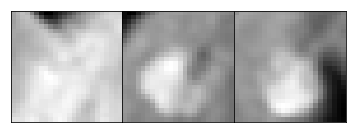

In [36]:
a=next(train_generator)
imgtrain = a[0][0][0]
img = imgtrain
print(np.amin(img), np.amax(img), np.mean(img))
hf.plot_section_auto(imgtrain[:,:,:,0])

-0.63184224858 0.858626179186 0.0104835658468


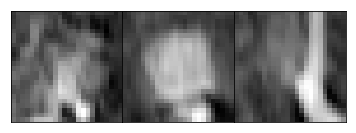

In [37]:
imgtest = X_train_orig[0][1]
img = imgtest
print(np.amin(img), np.amax(img), np.mean(img))
hf.plot_section_auto(imgtest[:,:,:,0])

In [4]:
model = keras.models.load_model(os.path.join(C.model_dir, "models_305.hdf5"))

In [17]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 3, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x[:,:,x.shape[2]//2,:]

In [ ]:
input_img = model.input

layer_name = 'conv3d_148'
for filter_index in range(4):  # can be any integer from 0 to 511, as there are 512 filters in that layer
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    input_img_data = np.ones((1, C.dims[0], C.dims[1], C.dims[2], 3)) * .2#np.random.random((1, C.dims[0], C.dims[1], C.dims[2], 3)) * 2.
    # run gradient ascent for 20 steps
    step = .8
    for i in range(50):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    img = deprocess_image(img)
    hf.plot_section_auto(img, save_path="E:\\filters_test\\%s_filter_%d.png" % (layer_name, filter_index))

In [64]:
importlib.reload(hf)

<module 'niftiutils.helper_fxns' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\helper_fxns.py'>

In [74]:
model_filter_outputs = cbuild.build_pretrain_model(model)

In [75]:
for l in range(1,len(model_filter_outputs.layers) - 2):
    model_filter_outputs.layers[l].set_weights(model.layers[l].get_weights())

In [ ]:
model.summary()

In [ ]:
model_filter_outputs.summary()

In [483]:
model_dense_outputs = cbuild.build_pretrain_model(model)

In [484]:
for l in range(1,len(model_dense_outputs.layers)):
    #if type(model_pretrain.layers[l]) == Conv3D:
    model_dense_outputs.layers[l].set_weights(model.layers[l].get_weights())

In [485]:
filter_results = {}
for cls in C.classes_to_include:
    filter_results[cls] = model_dense_outputs.predict(orig_data_dict[cls][0], verbose=False)

In [486]:
filter_avgs = np.concatenate([filter_results[cls] for cls in C.classes_to_include], axis=0)
filter_avgs = np.mean(filter_avgs, axis=0)

In [487]:
filter_cls_avg_unscaled = {cls: np.mean(filter_results[cls], axis=0) for cls in C.classes_to_include}

In [488]:
filter_cls_avg_scaled = {cls: np.mean(filter_results[cls], axis=0) / filter_avgs for cls in C.classes_to_include}

In [115]:
with open('E:\\filters.csv', 'w', newline='') as csvfile:
    header = ['filter_num'] + C.classes_to_include
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for f_num in range(100):
        writer.writerow([f_num] + [filter_cls_avg_scaled[cls][f_num] for cls in C.classes_to_include])

In [560]:
feature_sheet = pd.read_excel(C.xls_name, "Descriptions")

features_by_cls = {}
feat_count = {}
for cls in C.classes_to_include:
    features_by_cls[cls] = list(feature_sheet["evidence1"+cls].dropna().values)
    features_by_cls[cls] = features_by_cls[cls] + list(feature_sheet["evidence2"+cls].dropna().values)
#all_features = list(set([f for cls in features for f in features[cls]]))

feat_count = dict(zip(*np.unique([f for cls in features_by_cls for f in features_by_cls[cls]], return_counts=True)))
all_features = list(feat_count.keys())
for cls in C.classes_to_include:
    features_by_cls[cls] = list(set(features_by_cls[cls]))

In [561]:
feat_count

{'arterial enhancement': 18,
 'central scar': 6,
 'continuous enhancing rim': 13,
 'delayed isointensity': 7,
 'hyperintense mass on delayed phase': 6,
 'hypointense without enhancement': 10,
 'infiltrative': 8,
 'lobulated margins': 7,
 'nodular enhancement': 11,
 'progressive and concentric enhancement': 4,
 'progressive enhancement': 14,
 'regular spherical shape': 9,
 'thin walls': 14,
 'venous washout': 10}

In [567]:
cls_features = {f: [c for c in C.classes_to_include if f in features_by_cls[c]] for f in all_features}

for col in [c for c in feature_sheet.columns if c.startswith("evidence")]:

In [519]:
Z_features_by_cls = {cls: {} for cls in features_by_cls}
Z_features = {}

for cls in C.classes_to_include:
    for f in features_by_cls[cls]:
        Z_features_by_cls[cls][f] = [x+".npy" for x in feature_sheet[feature_sheet["evidence1"+cls] == f][cls].values] + \
                        [x+".npy" for x in feature_sheet[feature_sheet["evidence2"+cls] == f][cls].values]
        if f not in Z_features:
            Z_features[f] = []
        Z_features[f] += [x+".npy" for x in feature_sheet[feature_sheet["evidence1"+cls] == f][cls].values] + \
                        [x+".npy" for x in feature_sheet[feature_sheet["evidence2"+cls] == f][cls].values]

In [540]:
feature_filters = {f:np.empty([0,100]) for f in all_features}#{cls: {} for cls in features}
feature_filters_scaled = {}#{cls: {} for cls in features}

In [541]:
for f in all_features:
    for cls in C.classes_to_include:
        x_features = orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_features[f]))]
        if x_features.size > 0:
            feature_filters[f] = np.concatenate([feature_filters[f], model_dense_outputs.predict(x_features, verbose=False)], axis=0)# / filter_avgs
        
    feature_filters[f] = np.mean(feature_filters[f], axis=0)# / filter_avgs

    ff = feature_filters[f]
    feature_filters[f] = np.where(ff > np.mean(ff), ff, 0)

    #ff = feature_filters[cls][f]
    #feature_filters[cls][f] = np.where(ff > 1*filter_cls_avg_unscaled[cls], ff, 0)

    ff = feature_filters[f]
    feature_filters[f] = np.where(ff > 1.3*filter_avgs, ff, 0)

    feature_filters_scaled[f] = feature_filters[f] / filter_avgs

In [441]:
header = ['filter_num']
for cls in C.classes_to_include:
    header += [f+"_"+cls for f in features[cls]]

with open('E:\\feature_filters.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for f_num in range(128):
        writer.writerow([f_num] + [feature_filters[cls][f][f_num] for cls in features for f in features[cls]])

In [442]:
all_features_cls = header[1:]

In [583]:
Z_test_full = ['E106097391_0.npy', 'E104978772_1.npy', '12900535_0.npy', 'E100150242_0.npy', 'E105490014_0.npy', 'E103147618_0.npy', 'E103510187_0.npy', 'E104657225_0.npy', 'E100551966_0.npy', 'E101388602_0.npy', 'E100215900_8.npy', 'E100215900_7.npy', 'E104045692_0.npy', '13104521_0.npy', 'E100383453_0.npy', '12943286_0.npy', '12271995_0.npy', 'E102315724_0.npy', 'E104949189_0.npy', 'E100511083_1.npy', 'E101579471_0.npy', '13018986_1.npy', '13203550_8.npy', '13112385_0.npy', '12712463_0.npy', '12361082_0.npy', '13028374_0.npy', 'E103985934_1.npy', 'E100529980_0.npy', '12042703_3.npy', '12961059_0.npy', 'E105724706_2.npy', 'E100592424_2.npy', 'E103104254_0.npy', 'E104546069_0.npy', 'E101665217_1.npy', '12090000_0.npy', 'E100592424_1.npy', '12961059_1.npy', 'E105474285_0.npy', '12502068_1.npy', 'E100814791_0.npy', 'E102613189_0.npy', 'E105427046_0.npy', 'E102881031_1.npy', 'E102929168_0.npy', 'E102310482_0.npy', 'E102095465_0.npy', 'E101811299_0.npy', 'E104737273_0.npy', '12890053_0.npy', 'E100168661_1.npy', '12637865_0.npy', 'E100168661_2.npy', '12239783_0.npy', '12707781_0.npy', '12706568_1.npy', '12823036_0.npy', '12404081_0.npy', '12365693_1.npy']

x_test = {cls: orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_test_full))] for cls in C.classes_to_include}
Z_test = {cls: orig_data_dict[cls][1][np.where(np.isin(orig_data_dict[cls][1], Z_test_full))] for cls in C.classes_to_include}

In [554]:
filters_test = {}
for cls in C.classes_to_include:
    filters_test[cls] = model_dense_outputs.predict(x_test[cls], verbose=False)
    #filters_test[cls] = np.apply_along_axis(lambda x: x / filter_avgs, 1, filters_test[cls])

In [552]:
def get_evidence_strength(feature_filters, pred_filters):
    """A good pred_filter has high values for all the key (non-zero) features of feature_filter.
    These values should be unscaled.
    Returns average percentage of the mean value of the key filters (capped at 100%)"""
    
    strength = 0
    num_key_filters = sum(feature_filters > 0)
    
    for i in range(len(pred_filters)):
        t = feature_filters[i]
        p = pred_filters[i]
        
        if t == 0:
            continue
            
        strength += min(p/t, 1)#t*p / filter_avgs[i]**.7
    return strength / num_key_filters

In [586]:
img_num = 0
evidence = {}
true_cls = "hcc"
max_strength = 0

cls = true_cls
"""for f in features[cls]:
    evidence[f] = get_evidence_strength(feature_filters[cls][f], filters_test[cls][img_num])
    max_strength = max(max_strength, evidence[f])
"""
#for cls in C.classes_to_include:
for f in all_features:
    evidence[f + "/" + str(cls_features[f])] = get_evidence_strength(feature_filters[f], filters_test[true_cls][img_num])
    #max_strength = max(max_strength, evidence[f + "/" + str(cls_features[f])])

#for f in evidence:
#    evidence[f] /= max_strength
output = {z:[] for z in Z_test_full}
print("Detected features:")
for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True)[:4]:
    #if strength > 1:
    print("- " + f, "- %d%%" % (strength*100))
    output.append([Z_test[true_cls][img_num], f, int(strength*100)])

Detected features:
- venous washout/['hcc'] - 71%
- arterial enhancement/['hcc', 'fnh'] - 58%
- continuous enhancing rim/['hcc', 'colorectal'] - 52%
- delayed isointensity/['fnh'] - 37%


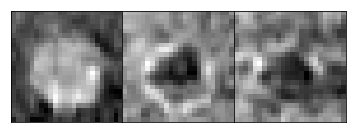

In [587]:
hf.plot_section_auto(x_test[true_cls][img_num])

In [597]:
x = np.expand_dims(x_test[true_cls][img_num], axis=0)

In [599]:
preds = model.predict(x, verbose=False)[0]

In [600]:
preds

array([  3.68678616e-06,   7.82114640e-08,   6.97524115e-07,
         4.62483013e-06,   2.23011739e-06,   9.99988675e-01], dtype=float32)

In [602]:
for pred_cls, pred_conf in sorted(zip(C.classes_to_include, preds), key=lambda x:x[1], reverse=True)[:5]:
    print(pred_cls, pred_conf)

fnh 0.999989
cyst 4.62483e-06
hcc 3.68679e-06
hemangioma 2.23012e-06
colorectal 6.97524e-07


In [604]:
output = {}
for true_cls in C.classes_to_include:
    for img_num in range(len(filters_test[true_cls])):
        z = Z_test[true_cls][img_num]
        x = np.expand_dims(x_test[true_cls][img_num], axis=0)
        evidence = {}
        max_strength = 0
        cls = true_cls
        
        output[z] = [true_cls]
        
        preds = model.predict(x, verbose=False)[0]
        for pred_cls, pred_conf in sorted(zip(C.classes_to_include, preds), key=lambda x:x[1], reverse=True)[:2]:
            output[z] = output[z] + [pred_cls, pred_conf]
        
        for f in all_features:
            evidence[f + "/" + str(cls_features[f])] = get_evidence_strength(feature_filters[f], filters_test[true_cls][img_num])

        for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True):
            output[z] = output[z] + [f, int(strength*100)]

In [605]:
with open('E:\\filters_pred.csv', 'w', newline='') as csvfile:
    header = ['img_fn', 'true_cls', 'pred_cls1', 'pred_conf1', 'pred_cls2', 'pred_conf2'] + \
            [s for i in range(len(all_features)) for s in ['feature_%d' % i,'strength_%d' % i]]
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for z_num in range(len(Z_test_full)):
        writer.writerow([Z_test_full[z_num]] + output[Z_test_full[z_num]])